### Importing necessary python libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


### Loading datasets

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

### Data Inspection

In [3]:
print(train_data.describe())
print(train_data.head(10))
print(train_data.shape)
print(train_data.isnull().sum())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
   PassengerId  Survived  Pclass  \
0            1         0       3   
1        

### Plotting correlation between age and survival count ( for Male and Female ) 

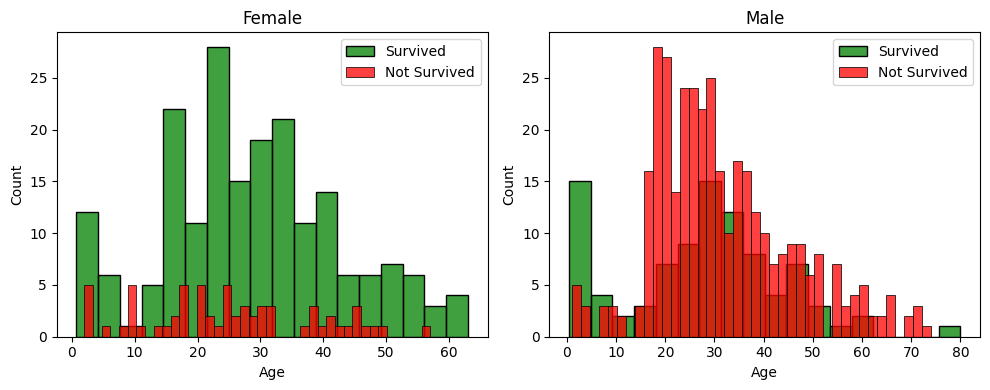

In [4]:
SURVIVED = 'Survived'
NOT_SURVIVED = 'Not Survived'
train_data['Sex'] = train_data['Sex'].map({'male': 1, 'female': 0})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

women = train_data[train_data['Sex'] == 0]
men = train_data[train_data['Sex'] == 1]

sns.histplot(women[women['Survived'] == 1].Age.dropna(), bins=18, label=SURVIVED, color='green', kde=False, ax=axes[0])
sns.histplot(women[women['Survived'] == 0].Age.dropna(), bins=40, label=NOT_SURVIVED, color='red', kde=False, ax=axes[0])
axes[0].legend()
axes[0].set_title('Female')

sns.histplot(men[men['Survived'] == 1].Age.dropna(), bins=18, label=SURVIVED, color='green', kde=False, ax=axes[1])
sns.histplot(men[men['Survived'] == 0].Age.dropna(), bins=40, label=NOT_SURVIVED, color='red', kde=False, ax=axes[1])
axes[1].legend()
axes[1].set_title('Male')

plt.tight_layout()
plt.show()


### Analyzing Survival Rates by Passenger Class and Age Distribution

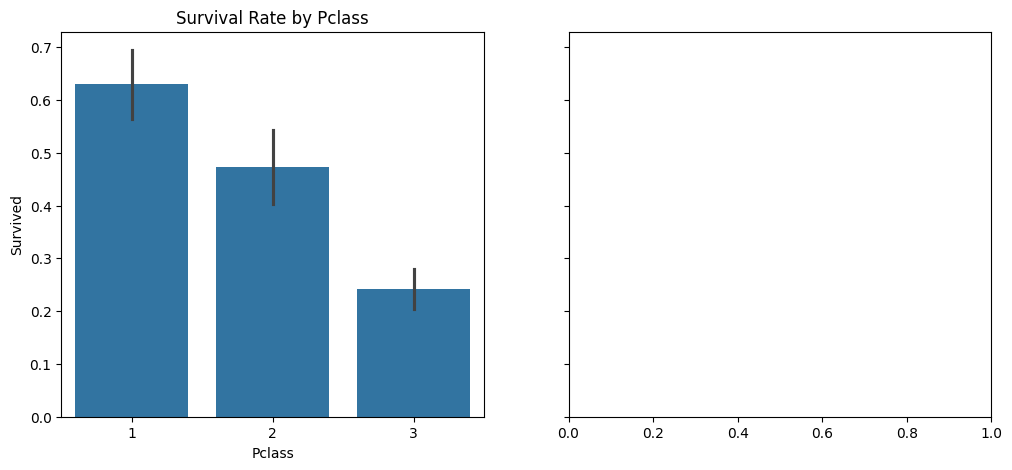

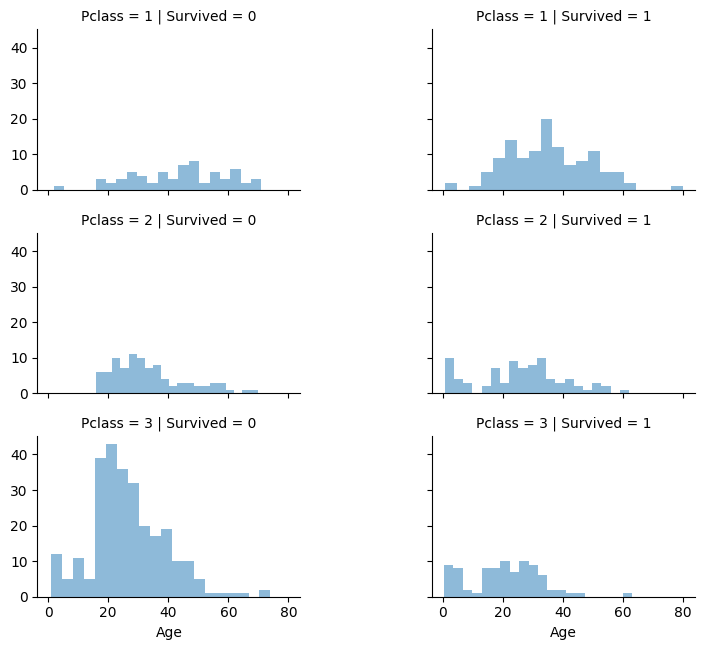

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

sns.barplot(x='Pclass', y='Survived', data=train_data, ax=axes[0])
axes[0].set_title('Survival Rate by Pclass')

grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


### Handling missing values

In [6]:
common_value_Embarked = train_data['Embarked'].mode()[0]
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value_Embarked)

In [7]:
train_data['Age'] = SimpleImputer(strategy='mean').fit_transform(train_data[['Age']])
train_data['Fare'] = SimpleImputer(strategy='mean').fit_transform(train_data[['Fare']])

In [8]:
common_value_Parch = train_data['Parch'].mode()[0]
common_value_SibSp = train_data['SibSp'].mode()[0]

for dataset in data:
    dataset['Parch'] = dataset['Parch'].fillna(common_value_Parch)
    dataset['SibSp'] = dataset['SibSp'].fillna(common_value_SibSp)

In [9]:
train_data = train_data.drop(columns=['Cabin', 'Ticket'])

In [10]:
train_data = train_data.drop_duplicates(subset=['PassengerId'])

def fill_random_id(row):
    if pd.isna(row['PassengerId']):
        return np.random.choice(train_data['PassengerId'].dropna().unique())
    else:
        return row['PassengerId']

train_data['PassengerId'] = train_data.apply(fill_random_id, axis=1)

In [11]:
common_value_Sex = train_data['Sex'].mode()[0]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].fillna(common_value_Sex)

In [12]:
def categorize_age(age):
    if age <= 5:
        return 1
    elif 6 <= age <= 10:
        return 2
    elif 11 <= age <= 15:
        return 3
    elif 16 <= age <= 20:
        return 4
    elif 21 <= age <= 30:
        return 5
    elif 31 <= age <= 40:
        return 6
    elif 41 <= age <= 50:
        return 7
    elif 51 <= age <= 60:
        return 8
    elif 61 <= age <= 70:
        return 9
    elif 71 <= age <= 80:
        return 10
    else:
        return 11
    
train_data['Age'] = train_data['Age'].apply(categorize_age)

In [13]:
def categorize_fare(fare):
    if fare <= 5:
        return 1
    elif 6 <= fare <= 10:
        return 2
    elif 11 <= fare <= 15:
        return 3
    elif 16 <= fare <= 20:
        return 4
    elif 21 <= fare <= 30:
        return 5
    elif 31 <= fare <= 40:
        return 6
    elif 41 <= fare <= 50:
        return 7
    elif 51 <= fare <= 75:
        return 8
    elif 76 <= fare <= 100:
        return 9
    else:
        return 10
    
train_data['Fare'] = train_data['Fare'].apply(categorize_fare)

### Preprocessing Data for Model Training Using Pipelines

In [14]:
X = train_data.drop(columns=['PassengerId', 'Survived', 'Name'])

y = train_data['Survived']

categorical_columns = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ], remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)


### Defining a List of Machine Learning Models for Evaluation

In [15]:
models = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=3),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    XGBClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    SGDClassifier()
]

### Identifying the Best Model Using F1 Score

In [16]:
best_model, best_f1 = None, 0

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1, best_model = f1, model

print(f"Best Model: {best_model.__class__.__name__}, F1 Score: {best_f1:.2f}")

Best Model: KNeighborsClassifier, F1 Score: 0.79


### Saving the Best Model for Future Use

In [17]:
with open('titanic_survivor_prediction.pkl', 'wb') as file:
    pickle.dump(best_model, file)